# Niche detection with CellCharter

In [1]:
# Run this cell when making changes to editable packages
# e.g., utils, cellcharter
%load_ext autoreload
%autoreload 2

In [ ]:
## Imports
import cellcharter as cc # imported as submodule
import squidpy as sq
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import os
import time
from scripts.utils.data_loading import *
from scripts.utils.niches import *
from scripts.utils.plotting.niches import *

/home/gesa/.py_venv/cellcharter/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Data preprocessing

In [ ]:
## Load data
# Load cell centroids & phenotype
adata2 = load_data_2D(centroids_to='obsm')
adata3_full = load_data_3D_full(centroids_to='obsm')
sections_2to3 = np.arange(10,141,10)    # which 3D neighbors views to create (indices of central 2D sections)
                                        # 3D neighbors view will be created from pre-processed 2D & 3D full views

# Load intensities (avg. marker intensities per 3D cell)
path = '../../data/Kuett_2022/MainHer2BreastCancerModel/model201710_mean_intensities.csv'
path_cellIDs = '../../data/Kuett_2022/MainHer2BreastCancerModel/model201710_cluster_labels_phenograph_recoded.csv'
intensities = pd.read_csv(path)
intensities.index = pd.read_csv(path_cellIDs)['id'].values # set cell IDs as index
intensities.drop('Ir193', axis=1, inplace=True) ## remove marker used as nuclear staining

/home/gesa/.py_venv/cellcharter/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/gesa/.py_venv/cellcharter/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/gesa/.py_venv/cellcharter/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


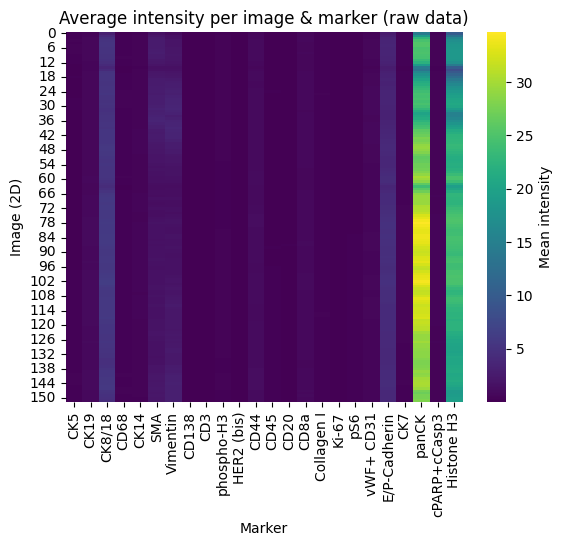

In [4]:
## Assessing intensity scale
cellID_to_imageID = adata2.obs[['id','z']].rename(columns={'id':'cellid', 'z':'imageid'})

## Plot average intensities per 2D image & marker
def avg_intensity_per_image_heatmap(
        intensities: np.ndarray,
        marker_names: np.ndarray, ## column names of intensities matrix
        cellIDs: np.ndarray, ## row names of intensities matrix
        cellID_to_imageID: pd.DataFrame, ## with column names 'cellid' and 'imageid'
        xlabel = 'Marker',
        ylabel = 'Image (2D)',
        title = None):
    
    # Calculate mean intensity per marker and imageid
    imageids = cellID_to_imageID['imageid'].unique()
    mat = np.empty((imageids.size, marker_names.size))
    for i, imageid in enumerate(imageids):
        cellIDs_sub = np.array( cellID_to_imageID.loc[ cellID_to_imageID['imageid'] == imageid, 'cellid'] ) ## cellIDs in current image
        int_ind = np.where( np.isin(cellIDs, cellIDs_sub) )[0] ## row indices of intensity matrix
        mat[i] = intensities[ int_ind, :].mean(axis=0) ## average intensity of each marker
    
    # Plot heatmap
    sns.heatmap(mat, cmap='viridis', cbar_kws={'label': 'Mean intensity'})
    plt.title(title)
    plt.xticks(ticks=np.arange(marker_names.size)+.5, labels=marker_names)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

avg_intensity_per_image_heatmap(
    np.array(intensities),
    intensities.columns,
    intensities.index,
    cellID_to_imageID,
    title = 'Average intensity per image & marker (raw data)')


In [33]:
## Normalize/scale data based on common methods in the field
int_norm = np.array(intensities)

# Transformations per marker
for i in range(int_norm.shape[1]):
    # Clip 99th percentile per marker
    int_norm[:, i] = np.clip(int_norm[:, i], a_min=0, a_max=np.percentile(int_norm[:, i], 99))
    # arcsinh transform
    int_norm[:, i] = np.arcsinh(int_norm[:, i])

# Scale data (over all markers)
int_norm = sc.pp.scale(int_norm)

assert np.isnan( int_norm.flatten() ).sum() == 0, "NaN values in normalized intensities"

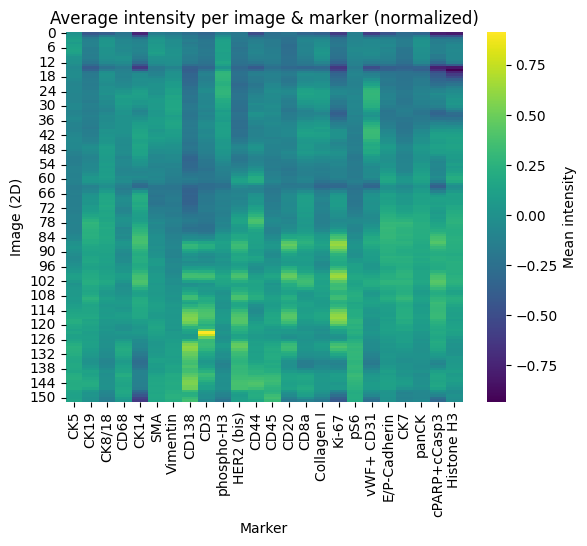

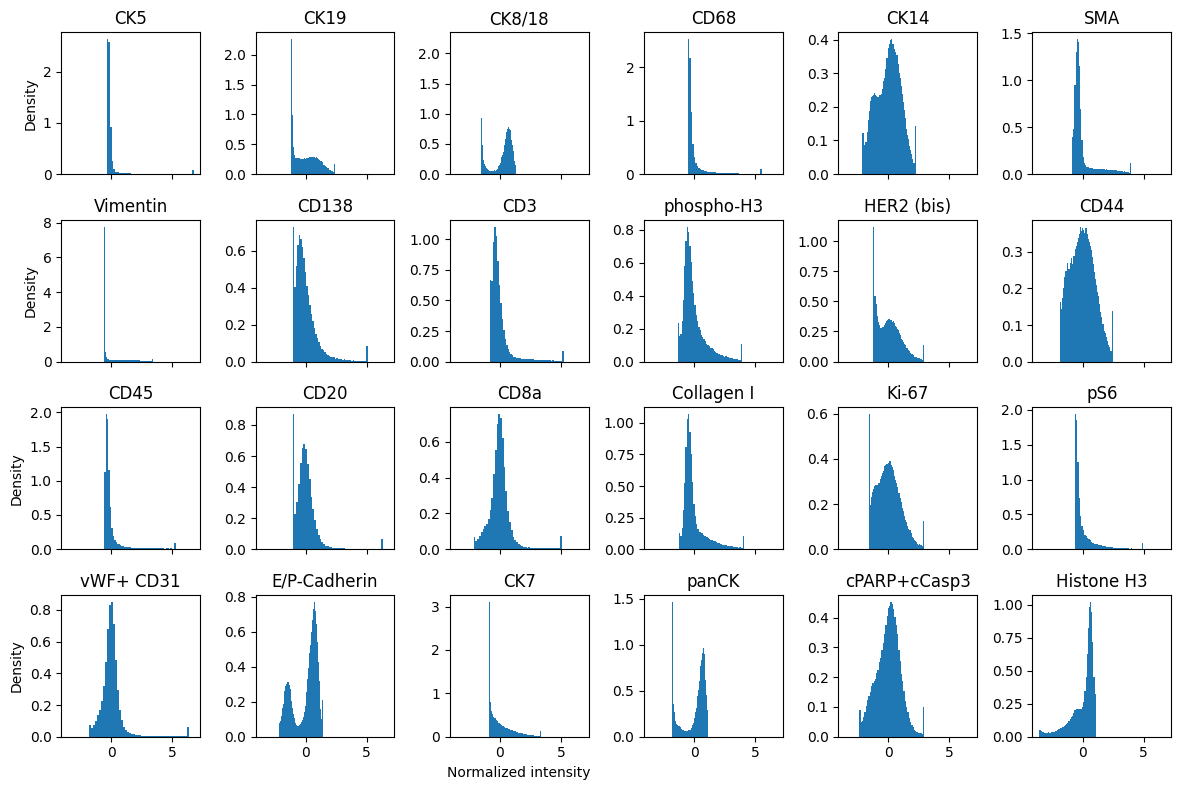

In [8]:
## Plot transformed data
# Heatmap
avg_intensity_per_image_heatmap(
    int_norm,
    intensities.columns,
    intensities.index,
    cellID_to_imageID,
    title = 'Average intensity per image & marker (normalized)')

# Histograms: normalized intensity per marker
fig, ax = plt.subplots(4, 6, figsize=(12,8), sharex=True)
for i in range(4):
    ax[i,0].set_ylabel('Density')
    for j in range(6):
        ax[i,j].hist(int_norm[:, i*6+j], bins=50, density=True)
        ax[i,j].set_title(intensities.columns[i*6+j])
ax[3,2].set_xlabel('Normalized intensity')
plt.tight_layout()
plt.show()

In [ ]:
## Assign normalized intensities to adata objects
int_norm = pd.DataFrame(int_norm, columns=intensities.columns, index=intensities.index) # index = id

# 2D
adata2 = ad.AnnData(
    X = int_norm.loc[ adata2.obs['id'].values, :].reset_index(drop=True),
    obs = adata2.obs,
    obsm = adata2.obsm )
# 3D full
adata3_full = ad.AnnData(
    X = int_norm.loc[ adata3_full.obs['id'].values, :].reset_index(drop=True),
    obs = adata3_full.obs,
    obsm = adata3_full.obsm )

## CellCharter workflow

In [ ]:
## Build spatial neighborhood graph
# Build graph
t0 = time.process_time()
sq.gr.spatial_neighbors(adata3_full, library_key=None, 
                        spatial_key='spatial', coord_type='generic', radius=radius, delaunay=False)
sq.gr.spatial_neighbors(adata2, library_key='z',
                        spatial_key='spatial', coord_type='generic', radius=radius, delaunay=False)
print("Time elapsed: ", time.strftime('%H:%M:%S', time.gmtime(int(time.process_time()-t0))) )

Time elapsed:  00:00:09


In [ ]:
## Aggregate neighbor features into feature vector per cell
n_layers = 1 ## How many 'layers' of neighbors around the index cell to include
aggregations = 'mean' ## How to aggregate the neighbor features

cc.gr.aggregate_neighbors(adata3_full, sample_key=None,
                          n_layers=n_layers, aggregations=aggregations)
cc.gr.aggregate_neighbors(adata2, sample_key='z',
                          n_layers=n_layers, aggregations=aggregations)
for i, adata in enumerate([adata3_full, adata2]):
    assert np.isnan(adata.obsm['X_cellcharter']).sum() == 0, "nan values in adata object %s, will cause error in model fitting" % i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Due to high computational expense, cluster stability analysis was performed on an HPC. See files ending in '_hpc.py' and '_hpc.slurm' in this directory for the scripts.

In [ ]:
## Save data to move to HPC
outdir_3D_full = '../../data/temp/Kuett2022_cellcharter/input/cellcharter_3D.h5ad'
outdir_2D = '../../data/temp/Kuett2022_cellcharter/input/sections/'
outdir_3D_nbrs = '../../data/temp/Kuett2022_cellcharter/input/min2/'

for outdir in [outdir_3D_nbrs, outdir_2D]:
    if not os.path.exists(outdir):
        os.makedirs(outdir)

# 3D full
adata3_full.write_h5ad(outdir_3D_full)

# 3D neighbors
for section in sections_2to3:
    adata = adata3_full[ np.isin(adata3_full.obs['id'].values, adata2[ adata2.obs['z']==section, :].obs['id'].values) ].copy()
    adata.obs = adata.obs[['id','ct_broad']] # strip to relevant columns
    adata.uns = {'spatial_neighbors': adata2.uns['spatial_neighbors']} # strip to relevant items
    adata.write_h5ad(outdir_3D_nbrs + f'cellcharter_s{section}.h5ad')

# 2D
for z in adata2.obs['z'].unique():
    adata = adata2[ adata2.obs['z'] == z, : ].copy()
    adata.obs = adata.obs[['id','z','ct_broad']] # strip to relevant columns
    adata.uns = {'spatial_neighbors': adata2.uns['spatial_neighbors']} # strip to relevant items
    adata.write_h5ad(outdir_2D + f'cellcharter_z{z}.h5ad')

In [ ]:
## Load results
n_clusters = (3,15)
indir2D = '../../data/temp/Kuett2022_cellcharter/sections/cellcharter_model_z*/'
indir3nbrs = '../../data/temp/Kuett2022_cellcharter/min2/cellcharter_model_s*/'


# 3D full
model_3D_full = cc.tl.ClusterAutoK.load("../../data/temp/Kuett2022_cellcharter/cellcharter_model_3D/")

# 3D neighbors
best_k = {}
stability_3Dnbrs = np.empty((sections_2to3.size, n_clusters[1]-n_clusters[0]+1))
for i, section in enumerate(sections_2to3):
    model_3D_nbrs = cc.tl.ClusterAutoK.load(indir3nbrs.replace('*', str(section)))
    best_k[i] = model_3D_nbrs.best_k
    stability_3Dnbrs[i,:] = model_3D_nbrs.stability.mean(1)
stability_3Dnbrs = pd.DataFrame(stability_3Dnbrs, index=sections_2to3, columns=np.arange(n_clusters[0], n_clusters[1]+1))
stability_3Dnbrs = stability_3Dnbrs.melt(var_name="N.clusters", value_name='Stability')

# 2D
best_k = {}
stability_2D = np.empty((adata2.obs['z'].unique().size, n_clusters[1]-n_clusters[0]+1))
for z in range(152):
    model_2D = cc.tl.ClusterAutoK.load(indir2D.replace('*', str(z)))
    best_k[z] = model_2D.best_k
    stability_2D[z,:] = model_2D.stability.mean(1)
stability_2D = pd.DataFrame(stability_2D, index=np.arange(152), columns=np.arange(n_clusters[0], n_clusters[1]+1))
stability_2D = stability_2D.melt(var_name="N.clusters", value_name='Stability')

In [ ]:
## Predict cluster labels using k of choice
# capture used to suppress output
ks = [3,4,5,6]

# Create 3D nbrs adata object
adata3_nbrs = adata2[ np.isin(adata2.obs['z'].values, sections_2to3) ].copy() # 2D cells and their imageID
adata3_nbrs.obs.rename(columns={'z':'section'}, inplace=True) # rename to match 3D data

for k in ks:
    adata3_full.obs[f'cluster_k{k}'] = model_3D_full.predict(adata3_full, k=k)

    for z in adata2.obs['z'].unique():
        model_2D = cc.tl.ClusterAutoK.load(indir2D.replace('*', str(z)))
        adata2.obs.loc[adata2.obs['z'] == z, f'cluster_k{k}'] = model_2D.predict(adata2[ adata2.obs['z'] == z ], k=k)

    for section in sections_2to3:
        model_3D_nbrs = cc.tl.ClusterAutoK.load(indir3nbrs.replace('*', str(section)))
        adata = adata3_full[ np.isin(adata3_full.obs['id'].values, adata2[ adata2.obs['z']==section, :].obs['id'].values) ].copy() # original data used to train model
        adata3_nbrs.obs.loc[ adata3_nbrs.obs['section'] == section, f'cluster_k{k}'] = model_3D_nbrs.predict(adata3_nbrs[ adata3_nbrs.obs['section'] == section ], k=k)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

## Assess results

In [ ]:
colors_phenotype = get_colors_phenotype()

### Full 3D image

In [38]:
## Recode cluster labels (to match later plots)
adata3_full.obs.cluster_k4 = adata3_full.obs.cluster_k4.map({0:0,1:3,2:2,3:1}).astype('category')

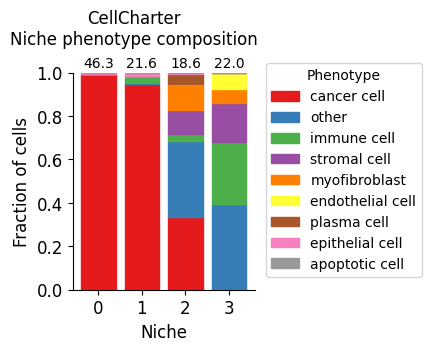

In [39]:
# Stacked barplot: phenotype composition of each niche
k = 4
niche = f'cluster_k{k}'

pt_order = list(adata3_full.obs.value_counts('ct_broad').index)

fig, ax = plt.subplots(figsize=(2.5,3.4), sharey=True, layout='constrained')
plt.suptitle(f'CellCharter\nNiche phenotype composition')
niche_pt_composition_subplot(
    adata3_full.obs[niche].copy(),
    adata3_full.obs['ct_broad'].copy(),
    ax=ax,
    sort_niches_by=np.arange(k),
    sort_phenotypes_by=pt_order,
    colors_phenotype=colors_phenotype,
    show_ncells=True, ncells_fraction=1000)
ax.set_ylabel('Fraction of cells', size='large')
ax.tick_params(axis='y', labelsize='large')
fig.legend(handles=[ mpatches.Patch(color=colors_phenotype[i], label=str(i)) for i in colors_phenotype.keys() ], # custom legend, otherwise redundant entries,
            title='Phenotype', bbox_to_anchor=(1, .85), loc='outside left upper')

#plt.savefig(f'../../figures/niches_cellcharter_pt_comp_k{k}_3Dfull.svg', bbox_inches='tight')
plt.show()

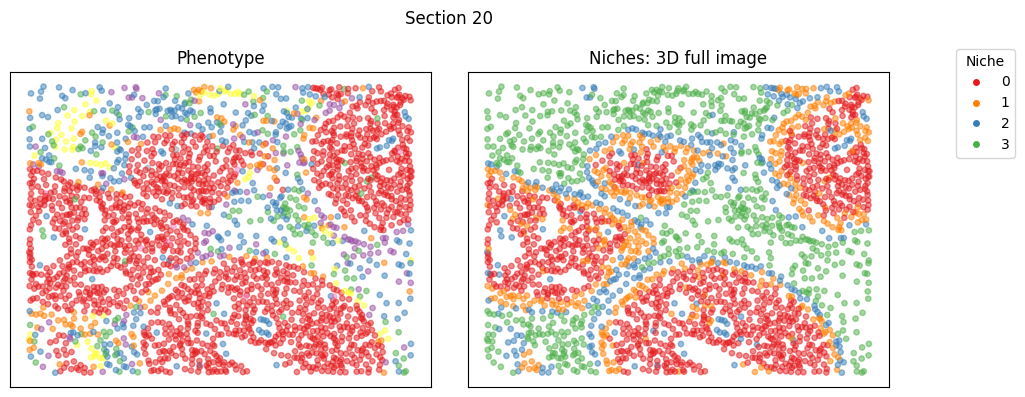

In [ ]:
## Plot phenotypes & niches on image
k = 4
section = 20

niche_col = f'cluster_k{k}'
ptype_col = 'ct_broad'

df = pd.DataFrame({
    'id': adata2[ adata2.obs['z']==section ].obs['id'].values,
    'x': adata2[ adata2.obs['z']==section ].obsm['spatial'][:,0],
    'y': adata2[ adata2.obs['z']==section ].obsm['spatial'][:,1] })
df = pd.merge(df, adata3_full.obs[['id',ptype_col,niche_col]], on='id', how='left')

# Color mapping
colors_niche = get_colors_niche(k)
colors_phenotype = get_colors_phenotype()
color_dicts = {
    ptype_col: colors_phenotype,
    niche_col: colors_niche }
subplot_categories = ['Phenotype', 'Niches: 3D full image'] # manual titles (must match plotting order!)

# Plot
fig, ax = plt.subplots(1,2,figsize=(10,4), layout='tight')
for i, cat in enumerate([ptype_col, niche_col]):
    ax[i].scatter(
        x=df['x'], y=df['y'],
        c=df[cat].map(color_dicts[cat]),
        s=15, alpha=.5)   
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_title(f'{subplot_categories[i]}')
    ax[i].axes.set_aspect('equal')

# Add legends
fig.legend(handles=[ Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_niche[i], label=str(i)) for i in np.arange(k) ], 
            title='Niche', bbox_to_anchor=(1, .9), loc='upper left')
plt.suptitle(f'Section {section}')

#plt.savefig(f'../../figures/niches_cellcharter_spatial_distribution_3Dfull_s{section}.svg', bbox_inches='tight')
plt.show()

### Comparing all views to each other

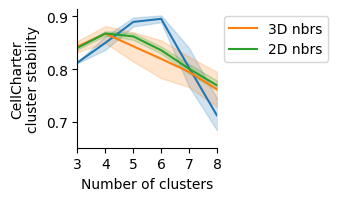

In [ ]:
## Plot stability results
fig, ax = plt.subplots(figsize=(1.8,1.8))
# 3D full (blue)
ax0 = cc.pl.autok_stability(model_3D_full, return_ax=True)
ax0.set_xlim(n_clusters[0], max_k)
# Local views
ax = sns.lineplot(stability_3Dnbrs.loc[ stability_3Dnbrs['N.clusters']<=max_k, :], 
                  x="N.clusters", y="Stability", label='3D nbrs')
ax = sns.lineplot(stability_2D.loc[ stability_2D['N.clusters']<=max_k, :], 
                  x="N.clusters", y="Stability", label='2D nbrs')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('CellCharter\ncluster stability')
ax.legend(bbox_to_anchor=(1., 1.))
plt.show()

In [ ]:
## Assess clustering similarity: ARI
ari_2_3nb = {}
ari_3f_2 = {}
ari_3f_3nb = {}
sections = sections_2to3
for k in ks:
    results_2_3nb = np.empty(sections.size)
    results_3f_2 = np.empty(sections.size)
    results_3f_3nb = np.empty(sections.size)
    for i, section in enumerate(sections):
        # Match cells between 2D and 3D by id
        subset_2 = adata2[ adata2.obs['z']==section ].obs.set_index('id')[f'cluster_k{k}' ]
        lbl_3nb = adata3_nbrs[ adata3_nbrs.obs['section']==section ].obs.set_index('id').loc[ subset_2.index, f'cluster_k{k}' ].astype(float).values
        lbl_3f = adata3_full.obs.set_index('id').loc[ subset_2.index, f'cluster_k{k}' ].astype(float).values
        lbl_2 = subset_2.astype(float).values
        # Remove NaNs in either vector
        mask = ~np.isnan(lbl_2) & ~np.isnan(lbl_3nb) & ~np.isnan(lbl_3f)
        lbl_2 = lbl_2[ mask ].astype(int)
        lbl_3nb = lbl_3nb[ mask ].astype(int)
        lbl_3f = lbl_3f[ mask ].astype(int)
        # Calculate ARI
        results_2_3nb[i] = adjusted_rand_score(lbl_2, lbl_3nb)
        results_3f_2[i] = adjusted_rand_score(lbl_3f, lbl_2)
        results_3f_3nb[i] = adjusted_rand_score(lbl_3f, lbl_3nb)
    ari_2_3nb[k] = results_2_3nb
    ari_3f_2[k] = results_3f_2
    ari_3f_3nb[k] = results_3f_3nb

In [10]:
print('median ARI\n\t3D full vs 2D\t3D full vs nbrs\t2D vs 3D nbrs')
for k in ks:
    line = f'k = {k}:\t'
    for ari in [ari_3f_2, ari_3f_3nb, ari_2_3nb]:
        line += f'{np.median(ari[k]):.2f}\t\t'
    print(line)

median ARI
	3D full vs 2D	3D full vs nbrs	2D vs 3D nbrs
k = 3:	0.79		0.72		0.81		
k = 4:	0.69		0.64		0.81		
k = 5:	0.70		0.64		0.73		
k = 6:	0.67		0.51		0.56		


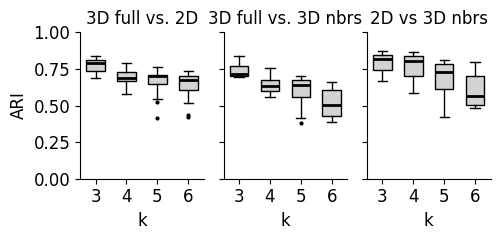

In [8]:
## ARI: 3D full vs {2D nbrs, 3D nbrs}
titles = ['3D full vs. 2D', '3D full vs. 3D nbrs', '2D vs 3D nbrs']
fig, ax = plt.subplots(1,3, figsize=(5,2.5), sharey=True, layout='tight')
for i, ari_dict in enumerate([ari_3f_2, ari_3f_3nb, ari_2_3nb]):
    ax[i].set_title(titles[i])
    for k in ks:
        ax[i].boxplot(
            ari_dict[k], patch_artist=True, positions=[k], widths=.6,
            boxprops=dict(facecolor='lightgrey', color='black'), # facecolor=colors[i]
            medianprops=dict(color='black', linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='black', markersize=2, linestyle='none'))
        ax[i].set_ylim(0,1)
        ax[i].tick_params(axis='both', labelsize='large')  
        ax[i].set_xlabel('k', size='large')
ax[0].set_ylabel('ARI', size='large')
sns.despine(top=True, right=True)

#plt.savefig('../../figures/niches_cellcharter_ari_allVall_boxplot.svg', bbox_inches='tight')
plt.show()

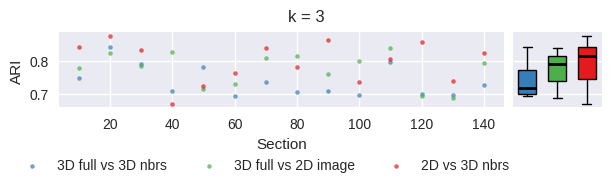

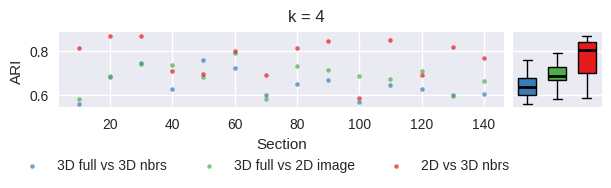

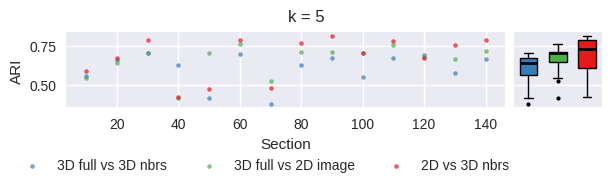

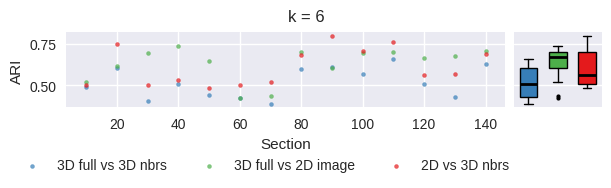

In [60]:
## Plot ARI
colors = ['#377eb8', '#4daf4a', '#e41a1c']
labels = ['3D full vs 3D nbrs', '3D full vs 2D image', '2D vs 3D nbrs']
with plt.style.context('seaborn-v0_8'):
    for k in ks:
        fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6,1.5), width_ratios=[5,1],
                               layout='constrained', sharey=True)
        fig.suptitle(f'k = {k}')
        # ARI scatter
        for i, ari in enumerate([ari_3f_3nb, ari_3f_2, ari_2_3nb]):
            ax0.scatter(sections, ari[k], label=labels[i],
                        s=8, alpha=.7, color=colors[i])
            ax1.boxplot(ari[k], patch_artist=True, positions=[i], widths=.6,
                        boxprops=dict(facecolor=colors[i], color='black'),
                        medianprops=dict(color='black', linewidth=2),
                        flierprops=dict(marker='o', markerfacecolor='black', markersize=2, linestyle='none'))
        ax0.set_xlabel('Section')
        ax0.set_ylabel('ARI')
        ax1.set_xticks([],[])
        
        fig.legend(bbox_to_anchor=(0,-.2), loc='lower left', ncol=3)
        if k == 4:
            pass  
            #plt.savefig(f'../../figures/niches_cellcharter_k{k}_ari_allVsall_nbrs.svg', bbox_inches='tight')
        plt.show()

### Comparison of local views

In [ ]:
k = 4
selection = [20,100] # high ARI, low ARI  # 20, 120
colors_niche = get_colors_niche(k)
colors_phenotype = get_colors_phenotype()

# Match and sort 2D & 3D cluster labels
niche_mapping = match_niches(selection, adata2, adata3_nbrs, 
                             niche_col=f'cluster_k{k}', k=k, coord_loc='obsm')

In [49]:
## Manual recoding -> better match of niche compositions between sections
df = niche_mapping[selection[0]]
new_mapping = {0:0,1:1,3:2,2:3}
df.niche_2D_mapped = df.niche_2D_mapped.map(new_mapping)
df.niche_3D_mapped = df.niche_3D_mapped.map(new_mapping)
niche_mapping[selection[0]] = df

df = niche_mapping[selection[1]]
new_mapping = {0:0,1:3,2:1,3:2}
df.niche_2D_mapped = df.niche_2D_mapped.map(new_mapping)
df.niche_3D_mapped = df.niche_3D_mapped.map(new_mapping)
niche_mapping[selection[1]] = df

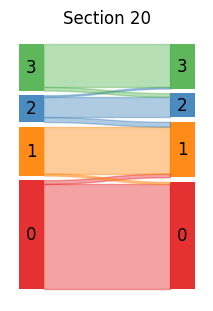

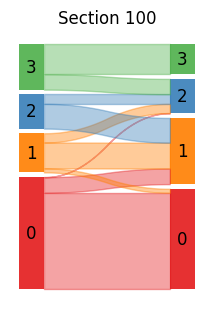

In [50]:
for section in selection:
    sankey_plot(niche_mapping[section], title=f'Section {section}')

## Save/load data

In [ ]:
## Save data
adata2.write_zarr("../../data/temp/Kuett_2022_cellcharter_2D.zarr")
adata3_full.write_zarr("../../data/temp/Kuett_2022_cellcharter_3D_full.zarr")
adata3_nbrs.write_zarr("../../data/temp/Kuett_2022_cellcharter_3D_min2.zarr")

In [ ]:
## Load data & params
ks = [3,4,5,6]
adata2 = ad.read_zarr("../../data/temp/Kuett_2022_cellcharter_2D.zarr")
adata3_full = ad.read_zarr("../../data/temp/Kuett_2022_cellcharter_3D_full.zarr")
adata3_nbrs = ad.read_zarr("../../data/temp/Kuett_2022_cellcharter_3D_min2.zarr")

In [ ]:
## Save environment specs
!pip freeze > ../../environment/niches_cellcharter.txt